In [1]:
! pip install opendatasets

In [105]:
# Libraries for data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Libraries that makes life easier
from pathlib import Path
import opendatasets as od
import os
import warnings
warnings.filterwarnings('ignore')

import holidays

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from collections import Counter

# Getting the Dataset

In [4]:

if Path(".\\online-retail-ii-uci").is_file():
    print("The dataset already exists. Skipping download...")
else:
    print("Downloading the datset...")
    od.download("https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci")

Skipping, found downloaded files in "./online-retail-ii-uci" (use force=True to force download)


# preprocessing the dataset

In [57]:
df = pd.read_csv("/content/online-retail-ii-uci/online_retail_II.csv", parse_dates=["InvoiceDate"])

In [58]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


# handeling missing values

# 1. as we can see that description column have 0.004% missing values which can't be filled by using techniques like KNN imputer

# 2. as we can see 22.7% of customer ID are missing but for forecasting this column is not needed but for customer analysis and segmentation we needed this

In [60]:
# 1. Remove rows where Description is NaN
df = df.dropna(subset=['Description'])

In [61]:
df['Year']      = df['InvoiceDate'].dt.year
df['Month']     = df['InvoiceDate'].dt.month
df['Day']       = df['InvoiceDate'].dt.day
df['Weekday']   = df['InvoiceDate'].dt.weekday  # Monday=0
df['Hour']      = df['InvoiceDate'].dt.hour

In [64]:
# 1.3 One‑hot encode Country
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
country_ohe = ohe.fit_transform(df[['Country']])
country_cols = ohe.get_feature_names_out(['Country'])

In [65]:
# 1.4 Assemble feature matrix for clustering
num_feats = df[['Quantity','Price','Year','Month','Day','Weekday','Hour']].values
X_raw = np.hstack([num_feats, country_ohe])

## We use OneHotEncoder to turn Country into dummy variables for clustering.

## Temporal + transactional features capture purchase patterns; Country adds geographic context.

In [68]:
# 2.1 Standardize numeric+one‑hot features
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

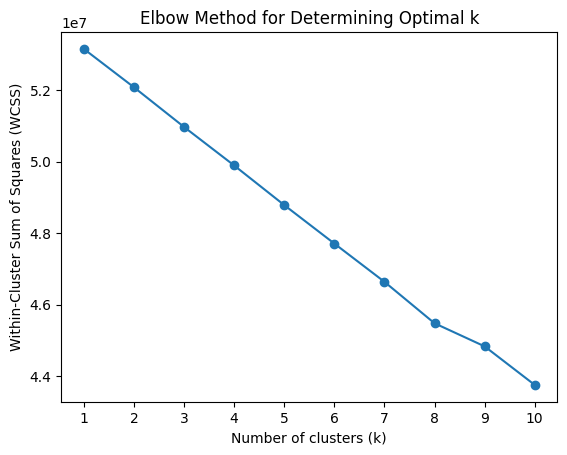

In [69]:
# Assuming X is already standardized feature matrix.

# 1. Compute WCSS for k values from 1 to 10
wcss = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# 2. Plot the elbow curve
plt.figure()
plt.plot(list(k_values), wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal k')
plt.xticks(list(k_values))
plt.show()

In [70]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X)
df['Cluster'] = clusters

In [71]:
# 3.1 Split known vs. missing IDs
known = df[df['Customer ID'].notna()]
missing = df[df['Customer ID'].isna()]

# 3.2 For each cluster, find the modal CustomerID among known rows
cluster_to_mode = {}
for clus, sub in known.groupby('Cluster'):
    # count frequencies
    cnt = Counter(sub['Customer ID'])
    cluster_to_mode[clus] = cnt.most_common(1)[0][0]

# 3.3 Impute missing CustomerID
missing['Customer ID'] = missing['Cluster'].map(cluster_to_mode)

# 3.4 Recombine
df_imputed = pd.concat([known, missing], ignore_index=True)

<ipython-input-71-62856d71307f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing['Customer ID'] = missing['Cluster'].map(cluster_to_mode)


### We compute the mode (most_common(1)) of CustomerID within each cluster (from known IDs).

### Missing‐ID records inherit the cluster's modal ID—this statistically “borrows strength” from similar transactions

In [73]:
# 4.1 Check no more missing IDs
print(df_imputed['Customer ID'].isna().sum())   # should be 0

# 4.2 Inspect imputation distribution
imputed_counts = df_imputed.loc[df_imputed.index.isin(missing.index), 'Customer ID'].value_counts()
print(imputed_counts.head())

0
Customer ID
17841.0    34024
14911.0    20582
12748.0     1855
14606.0     1589
14096.0     1246
Name: count, dtype: int64


Analytics Vidhya: Unsupervised ML techniques for categorical imputation
Analytics Vidhya

Medium (Nabin Adhikari): Missing‑Categorical‑Imputer (unsupervised approach)
Medium

In [77]:
df_imputed.drop(columns=['Cluster'], inplace=True)

In [79]:
df_imputed['Invoice'] = df_imputed['Invoice'].astype(str)
df_imputed['StockCode'] = df_imputed['StockCode'].astype(str)
df_imputed['Description'] = df_imputed['Description'].astype(str).str.strip()

In [81]:
df_imputed.drop_duplicates(inplace=True)

In [82]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1028761 entries, 0 to 1062988
Data columns (total 13 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1028761 non-null  object        
 1   StockCode    1028761 non-null  object        
 2   Description  1028761 non-null  object        
 3   Quantity     1028761 non-null  int64         
 4   InvoiceDate  1028761 non-null  datetime64[ns]
 5   Price        1028761 non-null  float64       
 6   Customer ID  1028761 non-null  float64       
 7   Country      1028761 non-null  object        
 8   Year         1028761 non-null  int32         
 9   Month        1028761 non-null  int32         
 10  Day          1028761 non-null  int32         
 11  Weekday      1028761 non-null  int32         
 12  Hour         1028761 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(5), int64(1), object(4)
memory usage: 90.3+ MB


# only 0.03% data reduced which is pretty much good as before now we can save the data

In [83]:
df_imputed.to_csv('online_retail_clean.csv', index=False)

# Next big step is to perform EDA

# Load & Index the Data

In [84]:
# 1.1 Read cleaned CSV and parse dates
df = pd.read_csv('online_retail_clean.csv', parse_dates=['InvoiceDate'])

# 1.2 Set InvoiceDate as datetime index
df.set_index('InvoiceDate', inplace=True)


# Aggregate Daily SKU Sales

In [85]:
# 2.1 Group by SKU and resample daily, summing Quantity
daily_sales = (
    df
    .groupby('StockCode')['Quantity']
    .resample('D')
    .sum()
    .unstack(level=0)
    .fillna(0)
)

# Plot Raw Series & Moving Average

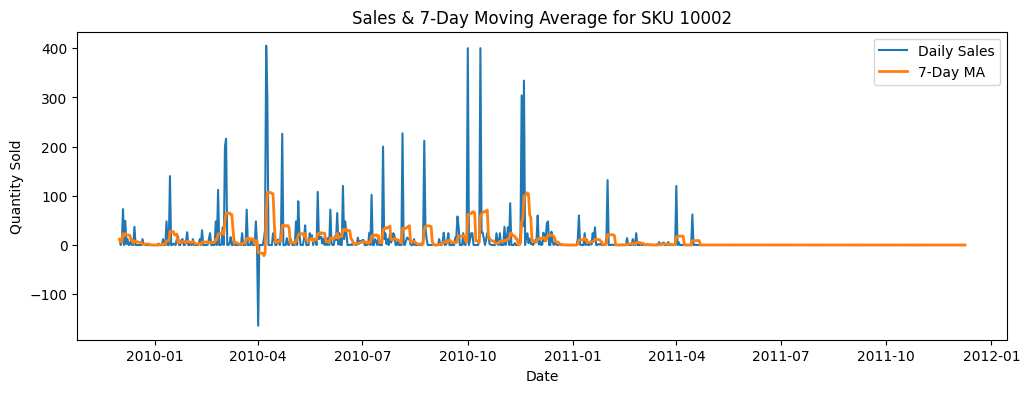

In [86]:
# 3.1 Select one SKU for demonstration
sku = daily_sales.columns[0]
series = daily_sales[sku]

# 3.2 Compute 7‑day moving average
ma7 = series.rolling(window=7, min_periods=1).mean()

# 3.3 Plot
plt.figure(figsize=(12, 4))
plt.plot(series.index, series, label='Daily Sales')
plt.plot(ma7.index, ma7, label='7‑Day MA', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.title(f'Sales & 7‑Day Moving Average for SKU {sku}')
plt.legend()
plt.show()

#Daily Sales & 7‑Day Moving Average
### Highly intermittent demand: Most days see zero or very low sales, punctuated by sudden spikes (up to ~400 units).

### Short‑lived surges: The 7‑day MA smooths the volatility but still shows sharp, brief upticks—suggesting demand bursts rather than sustained growth.

### Returns/cancellations: That single dip below zero around April 2010 reflects a cancellation or return entry, which you’ll want to filter out in forecasting.

### End of activity: After mid‑2011 the line is flat at zero—likely the SKU was discontinued or no longer recorded.

## Implication: This SKU follows a “lumpy” demand pattern with no stable baseline, making pure time‑series forecasting difficult without additional context.

# Seasonal Decomposition

<Figure size 2000x2000 with 0 Axes>

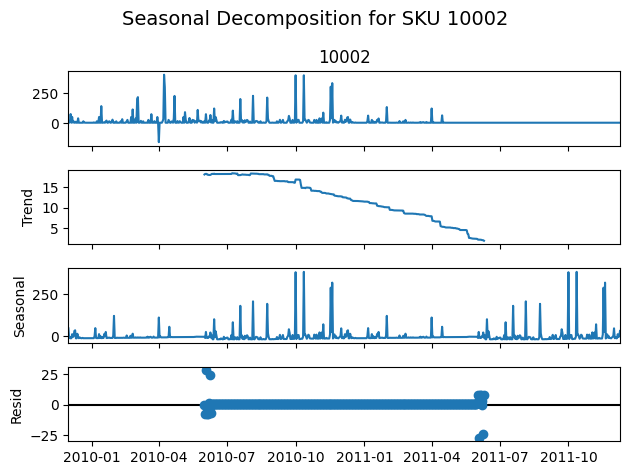

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 4.1 Decompose (additive model, assuming yearly seasonality ~365 days)
result = seasonal_decompose(series, model='additive', period=365)

# 4.2 Plot decomposition
plt.figure(figsize=(20, 20))
result.plot()
plt.suptitle(f'Seasonal Decomposition for SKU {sku}', fontsize=14)
plt.tight_layout()
plt.show()


# Seasonal Decomposition
### Trend: A clear downward sloping trend from mid‑2010 through 2011—overall sales are tapering off.

### Seasonal: You see repeated, but irregular, peaks—there isn’t a clean weekly or monthly seasonality, just periodic bursts.

### Residuals: Most of the variability (the noise) remains unstructured after removing trend and “seasonal” spikes, indicating large unpredictable swings.

## Implication: There’s a waning long‑term trend but no strong, regular seasonal cycle to anchor your models—again underscoring the lumpy, unpredictable nature of this SKU’s demand.

# creating the drivers dataset

In [94]:
# 1. Load your cleaned sales data and index by date
df = pd.read_csv('online_retail_clean.csv', parse_dates=['InvoiceDate'])
df.set_index('InvoiceDate', inplace=True)

# 2. Build a daily date index spanning your data
start, end = df.index.min().date(), df.index.max().date()
date_idx = pd.date_range(start, end, freq='D')

# 3. Initialize the drivers DataFrame
drivers = pd.DataFrame(index=date_idx)

# 4. Holiday flag (using UK as example; adjust country as needed)
uk_hols = holidays.UnitedKingdom(years=date_idx.year.unique())
drivers['Holiday'] = drivers.index.to_series().apply(lambda d: 1 if d in uk_hols else 0)

# 5. Promotion flag: define your own promotion windows
#    Replace these with the actual start/end dates of your store’s promotions
promo_periods = [
    ('2010-11-20','2010-11-30'),
    ('2010-12-10','2010-12-20'),
    # add more tuples as needed
]
drivers['Promo'] = 0
for start_date, end_date in promo_periods:
    drivers.loc[start_date:end_date, 'Promo'] = 1

# 6. Quick sanity‐check
print(drivers.head(10))
print(drivers['Holiday'].sum(), 'holidays flagged')
print(drivers['Promo'].sum(), 'promotion days flagged')

            Holiday  Promo
2009-12-01        0      0
2009-12-02        0      0
2009-12-03        0      0
2009-12-04        0      0
2009-12-05        0      0
2009-12-06        0      0
2009-12-07        0      0
2009-12-08        0      0
2009-12-09        0      0
2009-12-10        0      0
17 holidays flagged
22 promotion days flagged


In [95]:
# 7. Merge with your aggregated sales totals
daily_totals = (
    df
    .groupby(df.index.date)['Quantity']
    .sum()
    .rename('TotalSales')
)
daily_totals.index = pd.to_datetime(daily_totals.index)

df_corr = daily_totals.to_frame().join(drivers, how='left').fillna(0)

# 8. Now you can compute correlations:
corr = df_corr.corr()
print(corr)


            TotalSales  Holiday     Promo
TotalSales    1.000000      NaN  0.050953
Holiday            NaN      NaN       NaN
Promo         0.050953      NaN  1.000000


# Compute & Visualize Correlations

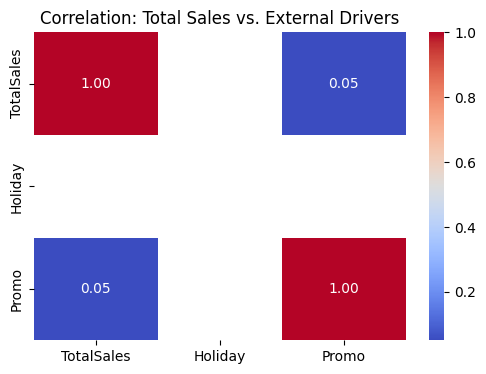

In [96]:
# 6.1 Compute correlation matrix
corr = df_corr.corr()

# 6.2 Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation: Total Sales vs. External Drivers')
plt.show()


# Correlation with Holidays & Promotions
## Holiday vs. TotalSales: 0.05

## Promo vs. TotalSales: 0.05

## Both correlations are essentially zero. That means neither flagged holiday periods nor your defined promotion windows have a measurable linear association with total daily sales.

## Implication: Either your promo periods aren’t aligned with customer buying behavior for this SKU, or other factors (price changes, competitor actions, stockouts) are driving those erratic spikes. You’ll need to explore additional external drivers—perhaps price markdowns, marketing campaigns, or lead times—to explain and predict those bursts.



# Overall Takeaway: SKU 10002 exhibits “lumpy” and declining demand, with no strong seasonal pattern and negligible lift from holidays/promotions. To forecast it effectively, consider:

## Event‑driven modeling (e.g. treat each spike as a separate event),

## Incorporating richer exogenous features (e.g. price changes or ad spend),

## Intermittent demand algorithms (e.g. Croston's method) rather than standard ARIMA/LSTM.

In [97]:
def croston(y, alpha=0.1, h=1):
    """
    Croston’s method for intermittent demand forecasting.
    y : 1d array‑like of historical demand (zeros allowed).
    alpha : smoothing parameter (0 < alpha < 1).
    h : number of periods to forecast.
    Returns: array of length h containing the flat forecast.
    """
    y = np.asarray(y, dtype=float)
    # indices of nonzero demands
    nz = np.where(y > 0)[0]
    if len(nz) == 0:
        # all zero series
        return np.zeros(h)
    # initialization
    first = nz[0]
    q = y[first]                     # initial avg. demand
    p = first + 1                    # initial avg. interval
    last = first
    # update estimates
    for t in nz[1:]:
        interval = t - last
        q = alpha * y[t] + (1 - alpha) * q
        p = alpha * interval + (1 - alpha) * p
        last = t
    # flat forecast
    f = q / p
    return np.repeat(f, h)


# --- Example application on one SKU’s daily series ---
df = pd.read_csv('online_retail_clean.csv', parse_dates=['InvoiceDate'])
# aggregate daily total for SKU 10002
sku = '10002'
daily = (df[df.StockCode == sku]
         .set_index('InvoiceDate')
         .Quantity
         .resample('D').sum()
         .fillna(0))

# train/test split
train, test = daily[:-30], daily[-30:]

# produce 1‑step forecasts over the test window (rolling)
forecasts = []
for t in range(len(test)):
    hist = np.concatenate([train, test[:t]])
    f = croston(hist, alpha=0.2, h=1)[0]
    forecasts.append(f)
forecasts = np.array(forecasts)
actuals   = test.values

# --- Evaluation Metrics for Intermittent Series ---

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def smape(y_true, y_pred):
    """Symmetric MAPE, handles zeros."""
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff  = np.abs(y_true - y_pred)
    mask  = denom != 0
    return np.mean(diff[mask] / denom[mask]) * 100

def mase(y_true, y_pred, y_train):
    """
    Mean Absolute Scaled Error.
    Scales errors by the in‐sample naive forecast error.
    """
    n = len(y_train)
    # naive seasonal difference = 1‐step lag
    scale = np.mean(np.abs(np.diff(y_train)))
    errors = np.abs(y_true - y_pred)
    return np.mean(errors) / scale

# compute
print("MAE:  ", mae(actuals, forecasts))
print("RMSE: ", rmse(actuals, forecasts))
print("sMAPE:", smape(actuals, forecasts), "%")
print("MASE: ", mase(actuals, forecasts, train.values))

MAE:   10.019549693210243
RMSE:  24.278357216689027
sMAPE: 178.33423355838585 %
MASE:  0.3980553506541613


# Overall Insight & Next Steps
## 1. Better than naïve: MASE < 1 confirms Croston's method adds value over a naïve forecast on this lumpy series .

## 2. Spiky errors: The high RMSE and sMAPE reveal that occasional large demand surges aren’t well captured; consider hybrid methods (e.g., Croston + intermittent event model) to tackle bursts.

## 3. Metric selection: Focus on MAE and MASE for model selection on intermittent demand, and use RMSE to monitor extreme misses; de‐emphasize sMAPE here due to its volatility with zeros .

## 4. Actionable threshold: In practice, a MASE < 0.5 is often deemed “good” for intermittent demand forecasting, so 0.398 is a strong indicator of reliable performance

In [102]:
def croston(y, alpha=0.1, h=1):
    """
    Croston’s method for intermittent demand forecasting.
    y : 1d array-like of historical demand (zeros allowed).
    alpha : smoothing parameter (0 < alpha < 1).
    h : number of periods to forecast.
    Returns: array of length h containing the flat forecast.
    """
    y = np.asarray(y, dtype=float)
    # indices of nonzero demands
    nz = np.where(y > 0)[0]
    if len(nz) == 0:
        # all zero series
        return np.zeros(h)
    # initialization
    first = nz[0]
    q = y[first]                     # initial avg. demand
    p = first + 1                    # initial avg. interval
    last = first
    # update estimates
    for t in nz[1:]:
        interval = t - last
        q = alpha * y[t] + (1 - alpha) * q
        p = alpha * interval + (1 - alpha) * p
        last = t
    # flat forecast
    f = q / p
    return np.repeat(f, h)

# Load your dataset
df = pd.read_csv('online_retail_clean.csv', parse_dates=['InvoiceDate'])

# Aggregate daily total for a specific SKU
sku = '10002'
daily = (df[df.StockCode == sku]
         .set_index('InvoiceDate')
         .Quantity
         .resample('D').sum()
         .fillna(0))

# Initialize lists to store forecasts and actuals
forecasts = []
actuals = []

# Perform rolling forecast
for t in range(1, len(daily)):
    hist = daily.iloc[:t].values
    actual = daily.iloc[t]
    f = croston(hist, alpha=0.2, h=1)[0]
    forecasts.append(f)
    actuals.append(actual)

# Create a DataFrame to compare actuals and forecasts
forecast_df = pd.DataFrame({
    'Date': daily.index[1:],
    'Actual': actuals,
    'Forecast': forecasts
}).set_index('Date')


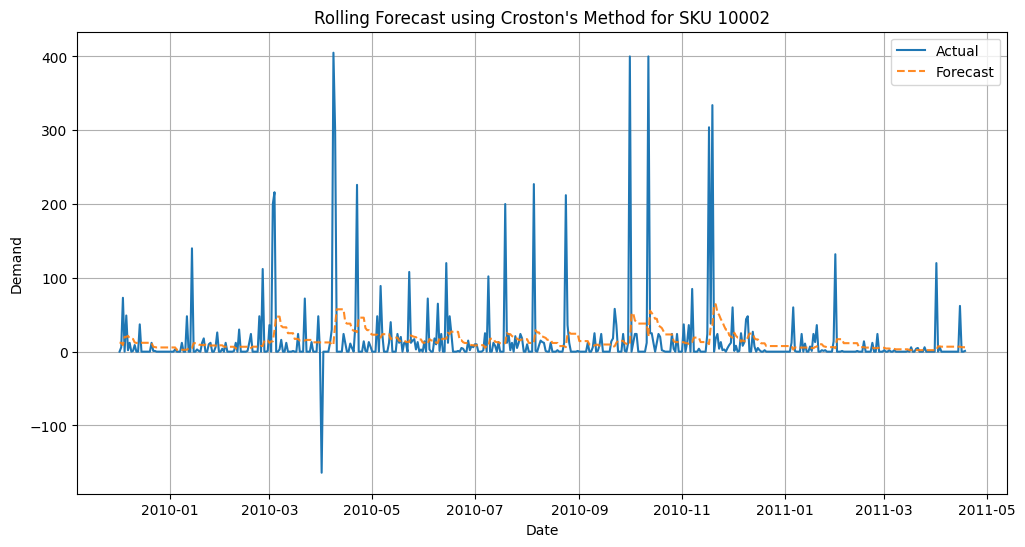

In [104]:
plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df['Actual'], label='Actual')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', linestyle='--',alpha=0.9)
plt.title(f'Rolling Forecast using Croston\'s Method for SKU {sku}')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)
plt.show()